In [1]:
import sys
import numpy as np
import pandas as pd
import sklearn
import pickle
from scipy.fft import fft, ifft

Read data along with parsed dates

In [2]:
#from google.colab import files
#uploaded = files.upload()

In [3]:
# read data from the files - parse Date and Time columns as DateTime
cgmDataOrig = pd.read_csv('CGMData.csv', parse_dates=[['Date', 'Time']])
insDataOrig = pd.read_csv('InsulinData.csv', parse_dates=[['Date', 'Time']])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (13,43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


**STORE ORIG DATA IN VARIABLES** (to be able to make changes and keep reading csv everytime)

In [4]:
# focus only on certain columns relevant to the dataset and Project 3
cgmData = cgmDataOrig.loc[:, ['Date_Time', 'Sensor Glucose (mg/dL)']]
insData = insDataOrig.loc[:, ['Date_Time', 'BWZ Carb Input (grams)']]

In [5]:
insData

,Date_Time,BWZ Carb Input (grams)
0,2018-02-12 13:20:53,NaN
1,2018-02-12 13:20:48,NaN
2,2018-02-12 13:18:48,NaN
3,2018-02-12 13:18:48,NaN
4,2018-02-12 13:12:33,NaN
...,...,...
41430,2017-07-24 19:00:01,NaN
41431,2017-07-24 18:59:44,NaN
41432,2017-07-24 18:59:44,NaN
41433,2017-07-24 18:59:44,NaN


# GET VALID DATE TIMES FOR MEAL DATA

COND 2: no tp between tm and tm + 2hrs

In [6]:
carbInputCond = ~insData['BWZ Carb Input (grams)'].isna() & insData['BWZ Carb Input (grams)']!=0
insCarbDT = insData[carbInputCond].copy(deep=True)

In [7]:
insCarbDT

,Date_Time,BWZ Carb Input (grams)
48,2018-02-12 09:15:45,34.0
129,2018-02-12 02:30:55,15.0
188,2018-02-11 20:33:18,71.0
207,2018-02-11 18:14:37,8.0
222,2018-02-11 16:27:04,40.0
...,...,...
41265,2017-07-26 11:24:52,20.0
41274,2017-07-26 09:27:16,72.0
41347,2017-07-25 18:31:40,115.0
41393,2017-07-25 10:39:46,58.0


In [8]:
# the last date_time value definitely MEAL DATA because it has its own 2hours of uninterrupted data
# get 2 hours 1 min value over last date_time
DT_max_2h1m = max(insCarbDT['Date_Time']) + pd.DateOffset(hours=2, minutes=1)

In [9]:
insCarbDT['Next_DT'] = insCarbDT['Date_Time'].shift(1, fill_value=DT_max_2h1m)
insCarbDT['DT+2hrs'] = insCarbDT['Date_Time'] + pd.DateOffset(hours=2)

In [10]:
insCarbDT[['Date_Time','Next_DT','DT+2hrs']]

,Date_Time,Next_DT,DT+2hrs
48,2018-02-12 09:15:45,2018-02-12 11:16:45,2018-02-12 11:15:45
129,2018-02-12 02:30:55,2018-02-12 09:15:45,2018-02-12 04:30:55
188,2018-02-11 20:33:18,2018-02-12 02:30:55,2018-02-11 22:33:18
207,2018-02-11 18:14:37,2018-02-11 20:33:18,2018-02-11 20:14:37
222,2018-02-11 16:27:04,2018-02-11 18:14:37,2018-02-11 18:27:04
...,...,...,...
41265,2017-07-26 11:24:52,2017-07-26 12:48:41,2017-07-26 13:24:52
41274,2017-07-26 09:27:16,2017-07-26 11:24:52,2017-07-26 11:27:16
41347,2017-07-25 18:31:40,2017-07-26 09:27:16,2017-07-25 20:31:40
41393,2017-07-25 10:39:46,2017-07-25 18:31:40,2017-07-25 12:39:46


In [11]:
btw2HrsCond = insCarbDT['Next_DT'].between(insCarbDT['Date_Time'], insCarbDT['DT+2hrs'], inclusive='neither')
insCarbDT = insCarbDT.loc[~btw2HrsCond]

In [12]:
insCarbDT

,Date_Time,BWZ Carb Input (grams),Next_DT,DT+2hrs
48,2018-02-12 09:15:45,34.0,2018-02-12 11:16:45,2018-02-12 11:15:45
129,2018-02-12 02:30:55,15.0,2018-02-12 09:15:45,2018-02-12 04:30:55
188,2018-02-11 20:33:18,71.0,2018-02-12 02:30:55,2018-02-11 22:33:18
207,2018-02-11 18:14:37,8.0,2018-02-11 20:33:18,2018-02-11 20:14:37
261,2018-02-11 12:43:23,27.0,2018-02-11 15:34:26,2018-02-11 14:43:23
...,...,...,...,...
41172,2017-07-27 05:45:51,24.0,2017-07-27 09:19:41,2017-07-27 07:45:51
41214,2017-07-26 19:15:06,60.0,2017-07-27 05:45:51,2017-07-26 21:15:06
41261,2017-07-26 12:48:41,63.0,2017-07-26 19:15:06,2017-07-26 14:48:41
41347,2017-07-25 18:31:40,115.0,2017-07-26 09:27:16,2017-07-25 20:31:40


COND 3: if tp is EXACTLY at tm+2hrs then keep both

In [13]:
# because we set the between function to have inclusive = 'neither' it keeps the above cond 3 true
# Now, only extract the Date_Time values
insCarbDT = insCarbDT.loc[:, ['Date_Time', 'BWZ Carb Input (grams)']]

In [14]:
insCarbDT

,Date_Time,BWZ Carb Input (grams)
48,2018-02-12 09:15:45,34.0
129,2018-02-12 02:30:55,15.0
188,2018-02-11 20:33:18,71.0
207,2018-02-11 18:14:37,8.0
261,2018-02-11 12:43:23,27.0
...,...,...
41172,2017-07-27 05:45:51,24.0
41214,2017-07-26 19:15:06,60.0
41261,2017-07-26 12:48:41,63.0
41347,2017-07-25 18:31:40,115.0


COND 1: keep tm-30min to tm+2hs as the MEAL interval to consider

In [15]:
# this condition is taken care of

* FUNCTION CREATING VALID MD ALONG WITH CARBS VALUE

In [129]:
# get the Valid MD DT and Carb values from Insulin data
def validInsulinDTCarbs(ins_data):
    carbInsCond = ~ins_data['BWZ Carb Input (grams)'].isna() & ins_data['BWZ Carb Input (grams)']!=0
    ins_data_carb = ins_data[carbInsCond].copy(deep=True)

    # the last date_time value is definitely MEAL DATA because it has its own 2hours of uninterrupted data
    # get 2 hours 1 min value over last date_time
    DT_max_2h1m = max(ins_data_carb['Date_Time']) + pd.DateOffset(hours=2, minutes=1)
    # create columns for next Date_TIME(DT) and DT+2hrs
    ins_data_carb['Next_DT'] = ins_data_carb['Date_Time'].shift(1, fill_value=DT_max_2h1m)
    ins_data_carb['DT+2hrs'] = ins_data_carb['Date_Time'] + pd.DateOffset(hours=2)

    # condition to check if Next_DT is between DT and DT+2hrs
    btw2HrsCond = ins_data_carb['Next_DT'].between(ins_data_carb['Date_Time'], ins_data_carb['DT+2hrs'], inclusive='neither')
    ins_data_carb = ins_data_carb.loc[~btw2HrsCond]

    # Now, only extract the Date_Time and Carb Input values
    insValDTCarbs = ins_data_carb.loc[:, ['Date_Time', 'BWZ Carb Input (grams)']]

    return insValDTCarbs

In [130]:
# run the validInsulinDTCarbs
insDT_Carbs = validInsulinDTCarbs(insData)

In [131]:
insDT_Carbs

,Date_Time,BWZ Carb Input (grams)
48,2018-02-12 09:15:45,34.0
129,2018-02-12 02:30:55,15.0
188,2018-02-11 20:33:18,71.0
207,2018-02-11 18:14:37,8.0
261,2018-02-11 12:43:23,27.0
...,...,...
41172,2017-07-27 05:45:51,24.0
41214,2017-07-26 19:15:06,60.0
41261,2017-07-26 12:48:41,63.0
41347,2017-07-25 18:31:40,115.0


# GET SENSOR VALUES IN CGMData FOR VALID DTs FOR MEAL DATA

In [19]:
cgmDT_Carbs = insDT_Carbs['Date_Time'].apply(lambda x: cgmData[cgmData['Date_Time'] >= x]['Date_Time'].min())

In [20]:
cgmDT_Carbs.iloc[::-1]

41393   2017-07-25 12:08:54
41347   2017-07-25 18:33:55
41261   2017-07-26 12:49:00
41214   2017-07-26 19:19:01
41172   2017-07-27 05:49:05
                ...        
261     2018-02-11 12:45:34
207     2018-02-11 18:17:22
188     2018-02-11 20:37:22
129     2018-02-12 02:32:25
48      2018-02-12 09:17:26
Name: Date_Time, Length: 604, dtype: datetime64[ns]

In [21]:
insDT_Carbs['BWZ Carb Input (grams)']

48        34.0
129       15.0
188       71.0
207        8.0
261       27.0
         ...  
41172     24.0
41214     60.0
41261     63.0
41347    115.0
41393     58.0
Name: BWZ Carb Input (grams), Length: 604, dtype: float64

In [22]:
meal_data_mat_ls_2 = []
lens_2 = []
for (ind, val) in cgmDT_Carbs.iloc[::-1].iteritems():
    if ind < 41172:
        break
    # different masks give different possible lengths of sensor values
    # the chosen mask exclude the time exactly at
    print(insDT_Carbs['BWZ Carb Input (grams)'][ind])
    #mask = (cgmDataPat_2['Date_Time'] >= val-pd.DateOffset(minutes=30)) & (cgmDataPat_2['Date_Time'] < val+pd.DateOffset(hours=2))
    #vals = np.array(cgmDataPat_2.loc[mask]['Sensor Glucose (mg/dL)'].iloc[::-1])
    #meal_data_mat_ls_2.append( vals )
    #lens_2.append( len(vals) )

58.0
115.0
63.0
60.0
24.0


In [23]:
x = np.array([1,2,3])
y = 23.0
np.append(x,y)

array([ 1.,  2.,  3., 23.])

* FUNCTION XTRACTING SENSOR VALUES FOR VALID DT

In [24]:
# get the CGM Sensor Values for each meal Data and the corresponding Carb Input value
def sensValAndCarbInput(insDT_Carbs_, cgmData_, threshold):
    # for each of valid Insulin Date_time get corresponding CGM DT after (but earliest) time
    cgmDT_Carbs_ = insDT_Carbs_['Date_Time'].apply(lambda x: cgmData_[cgmData_['Date_Time'] >= x]['Date_Time'].min())

    cgmDataList = []
    lengthsList = []

    # reverse the CGM DT Carbs values to make it chronologic order
    # while doing so loop through it
    for (ind, val) in cgmDT_Carbs_.iloc[::-1].iteritems():
        # for each value here we extract all Sensor Glucose values
        mask = (cgmData_['Date_Time'] >= val-pd.DateOffset(minutes=30)) & (cgmData_['Date_Time'] < val+pd.DateOffset(hours=2))
        sens_vals = np.array(cgmData_.loc[mask]['Sensor Glucose (mg/dL)'].iloc[::-1])
        nonNALen = np.count_nonzero(~np.isnan(sens_vals))
        # also add the Carb Input at the end
        carb_inp_val = insDT_Carbs_['BWZ Carb Input (grams)'][ind]
        comb_vals = np.append(sens_vals, carb_inp_val)

        # we only want the data if the non-NaN length is THRESHOLD% or more of 30 (>=24)
        # AND also the length of data must be 30
        if (len(sens_vals)==30 and nonNALen >= (threshold/100)*30):
            cgmDataList.append( comb_vals )
            lengthsList.append( nonNALen )

    cgmDataList = np.vstack(cgmDataList)

    # return list of lists as ndarray
    return np.array(cgmDataList), lengthsList


In [25]:
# set threshold for NaN in meal data
threshold = 80
mdMat_Carbs, lenList = sensValAndCarbInput(insDT_Carbs, cgmData, threshold)
# NOTE: last column in matrix is Carbs Input for that Meal Data from Insulin Data

In [301]:
mdMat_Carbs[0]

array([ 58.,  59.,  63.,  71.,  81., 102., 131., 140., 147., 153., 159.,
       163., 159., 153., 151., 155., 163., 164.,  nan, 166., 168., 164.,
       169., 178., 184., 190., 195., 198., 203., 196., 115.])

# FEATURE EXTRACTOR

* FUNCTION XTRACTING FEATURES FROM A MATRIX

In [186]:
def feat_extr(data_mat, select_feat):
    # variable to store list of lists (the inner list is list of 8 params)
    feat_mat_list = []
    # for each row create a list of 8 values (8 feature paramters)
    for idx, row in enumerate(data_mat):
        # create a list of 8 values/paramaeters
        feat_list = []

        # for each row consider minimum value index as tm value
        tm = np.nanargmin(row)

        # PARAMETER 1: difference between time at CGMMax and time at meal taken
        if select_feat[0] == 1:
            tau = (np.nanargmax(row) - tm)
            feat_list.insert(len(feat_list), tau)

        # PARAMETER 2: difference between CGMMax and CGM at time of meal taken
        if select_feat[1] == 1:
            CGMDiffNorm = (np.nanmax(row) - row[tm])#/row[tm]
            feat_list.insert(len(feat_list), CGMDiffNorm)

        # PARAMETER 3,4,5,6: get FFT magnitude and frequency bins
        if ((select_feat[2] == 1) or (select_feat[3] == 1) or (select_feat[4] == 1) or (select_feat[5] == 1)):
            nonNARow = row[~np.isnan(row)]
            # fft
            fft_vals = fft( nonNARow )
            # extract second and third peaks
            fft_vals_copy = fft_vals
            fft_vals_copy.sort()
            sec_max = fft_vals_copy[-2]
            thrd_max = fft_vals_copy[-3]
            # extract the indices of second and third peaks
            sec_max_ind = np.where(fft_vals==sec_max)[0][0]
            thrd_max_ind = np.where(fft_vals==thrd_max)[0][0]
            # add values to feat list
            if select_feat[2] == 1:
                feat_list.insert(len(feat_list), abs(sec_max))
            if select_feat[3] == 1:
                feat_list.insert(len(feat_list), sec_max_ind)
            if select_feat[4] == 1:
                feat_list.insert(len(feat_list), abs(thrd_max))
            if select_feat[5] == 1:
                feat_list.insert(len(feat_list), thrd_max_ind)

        # PARAMETER 7: differential of CGM data (GET MAX VALUE)
        if select_feat[6] == 1:
            feat_list.insert(len(feat_list), np.nanmax(np.diff(row)))

        # PARAMETER 8: double differential of CGM data
        if select_feat[7] == 1:
            feat_list.insert(len(feat_list), np.nanmax(np.diff(row, n=2)))

        # add updated feature to feat_mat_list
        feat_mat_list.append(feat_list)

    return np.array(feat_mat_list)

In [320]:
slct_ft = [1, 1, 1, 1, 1, 1, 1, 1]
# pass all but final (Carbs) column to feature extractor
mdFT = feat_extr(mdMat_Carbs[:,:-1], slct_ft)
# variable storing only carbs values
mdCarbs = mdMat_Carbs[:,-1].reshape((-1,1))
# rejoin the carbs column to the extracted features
mdFT_Carbs = np.column_stack( (mdFT, mdMat_Carbs[:,-1]) )
print("FEAT Matrix shape for MD"+str(mdFT.shape))
print("CARBS Matrix shape for MD"+str(mdCarbs.shape))

FEAT Matrix shape for MD(477, 8)
CARBS Matrix shape for MD(477, 1)


# CREATE BINS AND ASSIGN BIN VALUES: on mdCarbs MATRIX

In [321]:
# ravel the 1 column matrix to 1D array
mdCarbs_rav = mdCarbs.ravel()

# get max and min of the Carbs values
max_Carbs = mdCarbs_rav.max()
min_Carbs = mdCarbs_rav.min()

# REQUIRED number of clusters are
req_num_clusters = int(np.rint((max_Carbs - min_Carbs)/20))

bins = np.arange(min_Carbs, max_Carbs, 20)
# make sure the min value is included in the first bin
bins[0] = min_Carbs-1

# get the ground truth values as bins
mdGT = np.digitize(mdCarbs_rav, bins, right=True) - 1
# SUBTRACTED 1 to get bin values starting at 0

print("GRND TRUTH Matrix shape for MD"+str(mdGT.shape))

# join the feature matrix (FT) and ground truth (GT) values
mdFT_GT = np.column_stack( (mdFT, mdGT) )
print("FT + GRND TRUTH Matrix shape for MD"+str(mdFT_GT.shape))
print("GRND TRUTH values unique count = "+str( np.unique(mdGT, return_counts=True) ))

GRND TRUTH Matrix shape for MD(477,)
FT + GRND TRUTH Matrix shape for MD(477, 9)
GRND TRUTH values unique count = (array([0, 1, 2, 3, 4, 5]), array([161, 126, 113,  47,  25,   5]))


# PERFORM CLUSTERING ON DATA - use mdFT/mdFT_GT matrix

* K-MEANS

In [322]:
# IMPORT REQUIRED CLUSTERING MODULES
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [323]:
# create k-means model
mod_KM = KMeans(n_clusters = req_num_clusters)
fitted_KM = mod_KM.fit( mdFT )

# RAISE ERROR: if the max iterations is reached
assert fitted_KM.n_iter_ < fitted_KM.max_iter, "KMEANS ERROR: took more than max_iters (no convergence)!"

# the labels given by KMeans
labels_KM = fitted_KM.labels_
# create list of clusters with the data points
lbls_uvals_KM = np.unique(labels_KM)
clust_list_KM = [ mdFT_GT[np.where(labels_KM==lbl)] for lbl in lbls_uvals_KM ]
print("FITTED MODEL LABELS shape for MD"+str(labels_KM.shape))
# NUMBER OF POINTS IN EACH LABELS
print("NUM POINTS for each label (KM) for MD:- "+str( np.unique(labels_KM, return_counts=True) ))
print("NUM POINTS in each cluster (KM) for MD:- "+str( [ len(clst) for clst in clust_list_KM ] ))

FITTED MODEL LABELS shape for MD(477,)
NUM POINTS for each label (KM) for MD:- (array([0, 1, 2, 3, 4, 5], dtype=int32), array([212,  28,  69,  12,  16, 140]))
NUM POINTS in each cluster (KM) for MD:- [212, 28, 69, 12, 16, 140]


* DBSCAN

In [324]:
# SSE of a data matrix
def sseFunc(data_mat_):
    # get mean along axis=0
    clust_cent = np.mean(data_mat_ ,axis=0)

    # this computes the SSE given the points and the mean of them as clust_cent
    return sum(np.linalg.norm(data_mat_-clust_cent, axis=1)**2)
#--------------------------------------------------------------------------------------------------------------------------------@
# BISECTING K-MEANS UNTIL REQ_K NUMBER OF CLUSTERS
# paramter 1 has NOISELESS - feature data (FT) + ground_truth (GT) (number of columns = Fl+1)
# paramter 2 contains the labels given by DBSCAN
# paramter 3 contains required number of clusters to bisect into
def bis_KM_till_k(dataFT_GT, lbls_DB, req_k):
    
    # get the unique values of the labels
    cur_lbls = lbls_DB
    lbl_uvals = np.unique(cur_lbls)

    # get current number of clusters
    cur_num_clust = len(lbl_uvals)

    # index data according to label to get the clusters - list of 2D arrays
    clust_dataFT_GT = [ dataFT_GT[np.where(cur_lbls==lbl)] for lbl in lbl_uvals ]

    # save the SSE calculated over the loops
    # go through each label, index that data and get SSE
    # NOTE: only pass the feature matrix section to the SSE function
    sse_list = [ sseFunc(cl_d[:,:-1]) for cl_d in clust_dataFT_GT ]

    # stopping condition is until we have total req_k amount of clusters
    while cur_num_clust < req_k:
        # get the index of maximum SSE and use it to get the data to bisect("bis")
        maxSSE_ind = np.argmax(sse_list)
        bis_dataFT_GT = clust_dataFT_GT[maxSSE_ind]

        # peform bisection on the feature matrix section of the bis_data
        mod_BKM = KMeans(n_clusters=2).fit(bis_dataFT_GT[:,:-1])

        # RAISE ERROR: if the max iterations is reached
        if mod_BKM.n_iter_ > mod_BKM.max_iter:
            return None
        assert mod_BKM.n_iter_ < mod_BKM.max_iter, "BIS-KMEANS ERROR: took more than max_iters (no convergence)!"

        # the labels given by B-KMeans
        labels_BKM = mod_BKM.labels_

        # from the bisection we put label 0 values at maxSSE_ind index and at same index in clust_data ...
        lbl_0_data = bis_dataFT_GT[np.where(labels_BKM==0)]
        lbl_0_sse = sseFunc(lbl_0_data[:,:-1])
        sse_list[maxSSE_ind] = lbl_0_sse
        clust_dataFT_GT[maxSSE_ind] = lbl_0_data

        # ... and add label 1 values at end of the sse_list and clust_data
        lbl_1_data = bis_dataFT_GT[np.where(labels_BKM==1)]
        lbl_1_sse = sseFunc(lbl_1_data[:,:-1])
        sse_list.append(lbl_1_sse)
        clust_dataFT_GT.append(lbl_1_data)

        # increment number of clusters
        cur_num_clust = cur_num_clust + 1

    return clust_dataFT_GT

DBSCAN Fitting Model

In [325]:
# create DBSCAN model
mod_DB = DBSCAN(eps=213, min_samples=5)
fitted_DB = mod_DB.fit( mdFT )

# the labels given by DBSCAN
labels_DB = fitted_DB.labels_

# NUMBER OF NOISE POINTS
print("% of Noise Points = " + str( (sum(labels_DB == -1)/len(labels_DB))*100 ))

# the number of clusters formed
max_label_DB = np.max(labels_DB)
print(max_label_DB)
# if the max number is -1 then RAISE ERROR
assert max_label_DB != -1, "DBSCAN ERROR: all labels are -1!"
# min label
min_label_DB = int(np.nanmin( np.where(labels_DB<0, np.nan, labels_DB) ))
print(min_label_DB)

print("Number of Clusters = " + str(max_label_DB - min_label_DB + 1))

print("NUM POINTS in each label (DB) for MD:- "+str( np.unique(labels_DB, return_counts=True) ))

# remove noise points
# no noise points (NoiseLess) condition
cond_NL = np.where(labels_DB!=-1)
labels_DB_NL = labels_DB[cond_NL]
mdFT_NL = mdFT[cond_NL]
mdGT_NL = mdGT[cond_NL]
mdFT_GT_NL = mdFT_GT[cond_NL]

#print("No noise points shapes: (FT - GT - FT_GT) = "+str(mdFT_NL.shape)+" - "+str(mdGT_NL.shape)+" - "+str(mdFT_GT_NL.shape))
# Bisecting K-Means until req_num_clusters is reached - PASS NOISELESS DATA
clust_list_DB_BKM = bis_KM_till_k(mdFT_GT_NL, labels_DB_NL, req_num_clusters)
print("NUM POINTS in each cluster (DB+BKM) for MD:- "+str( [ len(clst) for clst in clust_list_DB_BKM ] ))

% of Noise Points = 0.628930817610063
0
0
Number of Clusters = 1
NUM POINTS in each label (DB) for MD:- (array([-1,  0]), array([  3, 474]))
NUM POINTS in each cluster (DB+BKM) for MD:- [153, 18, 84, 30, 139, 50]


# TEST DBSCAN PARAMTERS SETUP (dont include in main.py)

In [326]:
# FIND THE MAX POSSIBLE DISTANCE IN THE DATASET (eps max val)
eps_max = -np.inf
for point1 in mdFT_GT[:,:-1]:
    for point2 in mdFT_GT[:,:-1]:
        dist = np.linalg.norm(point1-point2)
        if dist > eps_max:
            eps_max = dist
eps_max = int(np.rint(eps_max))
# FIND THE MAX NUMBER OF POINTS IN THE DATASET (minpts max val)
mpts_max = mdFT_GT.shape[0]
print("EPS MAX = "+str(eps_max)+" MINPTS MAX = "+str(mpts_max))

EPS MAX = 2464 MINPTS MAX = 477


* get OPTIMAL eps values based on data mdFT_GT

144.2705471065182

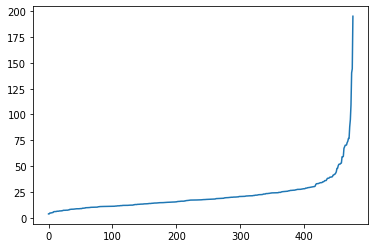

In [327]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(mdFT)
distances, indices = nbrs.kneighbors(mdFT)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

good_eps = distances[np.argmax(np.diff(distances))]
good_eps

In [ ]:
# run DBSCAN for different epsilon and min_samples
gt_point = np.array(np.sort(np.unique(mdGT, return_counts=True)[1]))
#dist_list = []
min_ent_params = []
max_pur_params = []
min_ent_F = np.inf
max_pur_F = -np.inf
eps_v = good_eps
ms_range = range(2,mpts_max)
if True:
    for ms_v in ms_range:
        mod_DB = DBSCAN(eps=eps_v, min_samples=ms_v)
        fDB= mod_DB.fit( mdFT )
        lDB = fDB.labels_
        if np.max(lDB) == -1:
            continue
        cnl = np.where(lDB!=-1)
        cl_DBKM = bis_KM_till_k(mdFT_GT[cnl], lDB[cnl], req_num_clusters)
        if cl_DBKM is None:
            continue
        #dbkm_point = np.array(np.sort([ len(clst) for clst in cl_DBKM ]))

        comp_Mat_ = clustCompConv(cl_DBKM, req_num_clusters)
        ent_ = entropyOfClusters(comp_Mat_)
        pur_ = purityOfClusters(comp_Mat_)

        #dist = np.linalg.norm(gt_point-dbkm_point)
        if ent_ < min_ent_F:
            min_ent_F = ent_
            min_ent_params.clear()
        if ent_ == min_ent_F:
            min_ent_params.append(ms_v)

        if pur_ > max_pur_F:
            max_pur_F = pur_
            max_pur_params.clear()
        if pur_ == max_pur_F:
            max_pur_params.append(ms_v)

        #if min_dist_GT == dist:
            #min_dist_params.append([eps_v, ms_v])
    print("GOOD VALUES:")
    print(min_ent_params)
    print(max_pur_params)

    with open('params.pkl', 'wb') as p_file:
        pickle.dump(min_dist_params, p_file)

print("MIN ENT:")
print(min_ent_F)
print("MAX PUR:")
print(max_pur_F)

In [311]:
mpts_val_sel = 

# GROUND TRUTH CLUSTER VALUES AND COUNTS
print("GRND TRUTH values unique count ="+str( np.sort(np.unique(mdGT, return_counts=True)[1]) ))
# K-MEANS CLUSTER VALUES AND COUNTS
print("K-MEANS values unique count =\t"+str( np.sort([ len(clst) for clst in clust_list_KM ]) ))
# DB-SCAN initial run
mod_DB = DBSCAN(eps=good_eps, min_samples=mpts_val_sel)
fitted_DB = mod_DB.fit( mdFT )
labels_DB = fitted_DB.labels_
max_label_DB = np.max(labels_DB)
assert max_label_DB != -1, "DBSCAN ERROR: all labels are -1!"
# run BIS-KM
cond_NL = np.where(labels_DB!=-1)
clust_list_DB_BKM = bis_KM_till_k(mdFT_GT[cond_NL], labels_DB[cond_NL], req_num_clusters)
print("DB+BKM values unique count =\t"+str( np.sort([ len(clst) for clst in clust_list_DB_BKM ]) ))
print("% of Noise Points = " + str( (sum(labels_DB == -1)/len(labels_DB))*100 ))
print("INIT-DBSCAN values unique count = "+str( np.unique(labels_DB, return_counts=True) ))
print("")
print("\tslct_ft = "+str(slct_ft))
print("\teps_set = "+str(good_eps))
print("\tmpts_set = "+str(mpts_val_sel))

GRND TRUTH values unique count =[  5  25  47 113 126 161]
K-MEANS values unique count =	[ 12  16  28  69 140 212]
DB+BKM values unique count =	[25 26 39 47 47 87]
% of Noise Points = 43.18658280922432
INIT-DBSCAN values unique count = (array([-1,  0]), array([206, 271]))

	slct_ft = [1, 1, 1, 1, 1, 1, 0, 0]
	eps_set = 140.27970853286342
	mpts_set = 271


In [266]:
#load params
#with open('params.pkl', 'rb') as params_file:
    #params = pickle.load(params_file)
#params

# MAKE CLUSTER COMPARISON MATRIX - 
# uses clust_list_KM AND clust_list_DB_BKM

In [109]:
print("K-MEANS values unique count =\t"+str( np.sort([ len(clst) for clst in clust_list_KM ]) ))
print("DB+BKM values unique count =\t"+str( np.sort([ len(clst) for clst in clust_list_DB_BKM ]) ))

K-MEANS values unique count =	[ 14  22  52 119 121 149]
DB+BKM values unique count =	[ 10  22  63 106 129 143]


* Function to take in clusters (which have GT) and output Clust Comp Matrix - usable on both KMeans and DBKM cluster lists

In [312]:
# converts clusters to matrix comparing with the ground truths
def clustCompConv(clust_list_, req_k):
    # storing the matrix of cluster count in each GT label
    comp_mat = []
    for clust_ in clust_list_:
        # ground truth labels
        clust_GT = clust_[:,-1]
        # get number of b0, ... bN-1 frequency in clust_GT (N = required number of clusters = req_k)
        comp_count = []
        for bi in range(req_k):
            bi_count = np.count_nonzero(clust_GT == bi)
            comp_count.append(bi_count)

        # add this list of counts to main comp_mat
        comp_mat.append(comp_count)

    return np.array(comp_mat)

In [313]:
# get the clust count comparison with the GT for KM
comp_Mat_KM = clustCompConv(clust_list_KM, req_num_clusters)
# and for DBKM clusters
comp_Mat_DBKM = clustCompConv(clust_list_DB_BKM, req_num_clusters)

In [314]:
comp_Mat_KM

array([[ 3,  4,  6,  2,  1,  0],
       [47, 35, 37, 15,  6,  0],
       [ 2,  8,  8,  6,  3,  1],
       [17, 10, 26,  9,  6,  1],
       [89, 65, 34, 14,  8,  2],
       [ 3,  4,  2,  1,  1,  1]])

In [315]:
comp_Mat_DBKM

array([[39, 22, 17,  4,  5,  0],
       [21, 15,  6,  4,  1,  0],
       [14,  7,  2,  1,  1,  1],
       [15, 19,  9,  3,  1,  0],
       [16,  7,  7,  8,  1,  0],
       [10,  8,  7,  0,  0,  0]])

# COMPUTE SSE, ENTROPY AND PURITY
# have: clust_list_KM, clust_list_DB_BKM, comp_Mat_KM, comp_Mat_DBKM

* SSE

In [316]:
# SSE for K-Means
clust_sse_KM = [ sseFunc(cl_) for cl_ in clust_list_KM ]
sse_KM = sum(clust_sse_KM)
print("SSE for KMeans = "+str(sse_KM))

# SSE for DB_BKM
clust_sse_DBKM = [ sseFunc(cl_) for cl_ in clust_list_DB_BKM ]
sse_DBKM = sum(clust_sse_DBKM)
print("SSE for DB+Kmeans = "+str(sse_DBKM))

SSE for KMeans = 4093917.7509308397
SSE for DB+Kmeans = 446645.66137955384


* ENTROPY

In [116]:
# ENTROPY function
def entropyOfClusters(clust_comp_mat_):
    # sum of elements in each row (=number of elements in the cluster represented in that row)
    num_elem_per_cluster_ = np.sum(clust_comp_mat_, axis=1, keepdims=True)

    # calculate fraction of total for each elemnt
    frac_ = clust_comp_mat_/num_elem_per_cluster_
    # NOTE: here division by zero - not possible
    # That would mean 0 elements in a cluster (not possible)

    # calculate -ve log of frac (entropy formula has a negative sign)
    # this ignores 0 when computing natural log (doesnt matter because it will get multiplies by 0 later)
    log_frac_ = -np.log(frac_, where=frac_!=0)

    # get frac times log frac
    frac_times_log_frac_ = np.multiply(frac_, log_frac_)

    # entropy for each row (each cluster)
    clust_ent_ = np.sum(frac_times_log_frac_, axis=1)

    # weight each cluster entropy with number of elements in cluster
    weight_clust_ent_ = np.multiply(num_elem_per_cluster_.ravel(), clust_ent_)

    # total entropy of entire matrix is
    tot_ent_ = sum(weight_clust_ent_)

    return tot_ent_

In [317]:
# ENTROPY for K-Means
ent_KM = entropyOfClusters(comp_Mat_KM)
print("ENTROPY for KMeans = "+str(ent_KM))

# ENTROPY for DB_BKM
ent_DBKM = entropyOfClusters(comp_Mat_DBKM)
print("ENTROPY for DB-BKM = "+str(ent_DBKM))

ENTROPY for KMeans = 684.668022576645
ENTROPY for DB-BKM = 351.9060322112338


* PURITY

In [318]:
# PURITY function
def purityOfClusters(clust_comp_mat_):
    # get max for each row
    max_per_row_ = clust_comp_mat_.max(axis=1)

    # add the max values
    sum_maxes_ = sum(max_per_row_)

    # divide by the total number of samples
    tot_pur_ = sum_maxes_/np.sum(clust_comp_mat_)

    return tot_pur_

In [319]:
# PURITY for K-Means
pur_KM = purityOfClusters(comp_Mat_KM)
print("PURITY for KMeans = "+str(pur_KM))

# PURITY for KDB-BKM
pur_DBKM = purityOfClusters(comp_Mat_DBKM)
print("PURITY for DB-BKM = "+str(pur_DBKM))

PURITY for KMeans = 0.37735849056603776
PURITY for DB-BKM = 0.43911439114391143


# WRITE THESE VALUES TO FILE - Result.csv
# format:-
SSE for Kmeans | SSE for DBSCAN | Entropy for KMeans | Entropy for DBSCAN | Purity for KMeans | Purity for DBSCAN (1x6 matrix)

In [120]:
# create a 1x6 matrix of result values
res_mat = np.array([sse_KM, sse_DBKM, ent_KM, ent_DBKM, pur_KM, pur_DBKM]).reshape((1,-1))
pd.DataFrame(res_mat).to_csv("Result.csv", sep=',', header=False, index=False )